In [1]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
import random
import shutil

def select_random_images(sat_folder, gt_folder, sat_folder_test, gt_folder_test, percentage=0.2):
    # Crear carpetas de destino si no existen
    os.makedirs(sat_folder_test, exist_ok=True)
    os.makedirs(gt_folder_test, exist_ok=True)
    
    # Obtener lista de archivos en la carpeta de imágenes satelitales, excluyendo los de la carpeta de prueba
    sat_files = [f for f in os.listdir(sat_folder) if os.path.isfile(os.path.join(sat_folder, f))]
    
    # Calcular el número de archivos a seleccionar
    num_files = int(len(sat_files) * percentage)
    
    # Seleccionar aleatoriamente el 20% de los archivos
    selected_files = random.sample(sat_files, num_files)
    
    # Mover cada archivo seleccionado y su máscara correspondiente
    for sat_file in selected_files:
        # Definir los caminos para la imagen satelital y la máscara
        sat_path = os.path.join(sat_folder, sat_file)
        gt_path_tiff = os.path.join(gt_folder, sat_file)
        gt_path_tif = os.path.join(gt_folder, sat_file.replace('.tiff', '.tif'))
        
        # Verificar si existe la máscara en formato .tiff o .tif
        if os.path.exists(gt_path_tiff):
            gt_path = gt_path_tiff
        elif os.path.exists(gt_path_tif):
            gt_path = gt_path_tif
        else:
            print(f"Warning: Missing mask for {sat_file}. Skipping this file.")
            continue
        
        # Definir los caminos de destino
        sat_dest = os.path.join(sat_folder_test, sat_file)
        gt_dest = os.path.join(gt_folder_test, os.path.basename(gt_path))
        
        # Mover los archivos
        shutil.move(sat_path, sat_dest)
        shutil.move(gt_path, gt_dest)
        
        print(f"Moved {sat_file} and corresponding mask to test folders.")
        



In [7]:
# Ejemplo de uso
sat_folder = 'DataSet_1/roads/sat'
gt_folder = 'DataSet_1/roads/gt'
sat_folder_test = 'DataSet_1/test/sat/'
gt_folder_test = 'DataSet_1/test/gt/'

select_random_images(sat_folder, gt_folder, sat_folder_test, gt_folder_test)

Moved 10528720_15.tiff and corresponding mask to test folders.
Moved 10528690_15.tiff and corresponding mask to test folders.
Moved 10528675_15.tiff and corresponding mask to test folders.
Moved 10528705_15.tiff and corresponding mask to test folders.


In [8]:
import os
import shutil

def reset_folders(sat_folder, gt_folder, sat_folder_test, gt_folder_test):
    # Obtener lista de archivos en las carpetas de prueba
    test_sat_files = os.listdir(sat_folder_test)
    test_gt_files = os.listdir(gt_folder_test)
    
    # Mover cada archivo de la carpeta de prueba a la carpeta original
    for test_file in test_sat_files:
        src_path = os.path.join(sat_folder_test, test_file)
        dest_path = os.path.join(sat_folder, test_file)
        shutil.move(src_path, dest_path)
    
    for test_file in test_gt_files:
        src_path = os.path.join(gt_folder_test, test_file)
        dest_path = os.path.join(gt_folder, test_file)
        shutil.move(src_path, dest_path)
    
    print("Todas las imágenes han sido devueltas a sus carpetas originales.")




In [9]:

# Ejecutar la función reset
# reset(sat_folder, gt_folder, sat_folder_test, gt_folder_test)

In [10]:
def convert_images_to_csv(sat_folder, gt_folder, output_csv_path):
    # List to store data from all images
    dataset = []
    
    # List available files in each directory to check for naming issues
    sat_files = sorted(os.listdir(sat_folder))
    gt_files = sorted(os.listdir(gt_folder))

    print("Satellite images found:", sat_files)
    print("Mask images found:", gt_files)

    for sat_file in sat_files:
        # Generate paths for both .tiff and .tif extensions
        sat_path = os.path.join(sat_folder, sat_file)
        gt_path_tiff = os.path.join(gt_folder, sat_file)
        gt_path_tif = os.path.join(gt_folder, sat_file.replace('.tiff', '.tif'))
        
        # Check if either .tiff or .tif version of the mask exists
        if os.path.exists(gt_path_tiff):
            gt_path = gt_path_tiff
        elif os.path.exists(gt_path_tif):
            gt_path = gt_path_tif
        else:
            print(f"Warning: Missing mask for {sat_file}. Skipping this file.")
            continue
        
        # Load images
        satellite_image = Image.open(sat_path)
        mask_image = Image.open(gt_path)
        
        # Convert images to numpy arrays
        satellite_array = np.array(satellite_image)
        mask_array = np.array(mask_image)
        
        # Ensure the satellite and mask images have matching dimensions
        if satellite_array.shape[:2] != mask_array.shape[:2]:
            print(f"Warning: Size mismatch for {sat_file}. Skipping this image pair.")
            continue
        
        # Flatten the arrays
        pixels_rgb = satellite_array.reshape(-1, 3)  # RGB features
        labels = mask_array.flatten()                # Binary labels (road or non-road)
        
        # Combine RGB values and labels
        image_data = np.column_stack((pixels_rgb, labels))
        
        # Append image data to dataset
        dataset.append(image_data)
    
    if dataset:
        # Concatenate all image data into a single dataset
        dataset = np.vstack(dataset)
        
        # Convert to DataFrame for easier manipulation and inspection
        df = pd.DataFrame(dataset, columns=['R', 'G', 'B', 'Label'])
        
        # Save DataFrame to a single CSV for machine learning training
        df.to_csv(output_csv_path, index=False)
        print(f"Dataset saved to {output_csv_path}")
    else:
        print("Error: No valid image data found. Check if files are correctly placed in 'sat' and 'gt' folders.")


In [11]:
output_csv = 'csv/RGBLabel.csv'

convert_images_to_csv(sat_folder, gt_folder, output_csv)

Satellite images found: ['10078675_15.tiff', '10228675_15.tiff', '10228705_15.tiff', '10228720_15.tiff', '10228735_15.tiff', '10228750_15.tiff', '10378675_15.tiff', '10378690_15.tiff', '10378705_15.tiff', '10378720_15.tiff', '10378735_15.tiff', '10378750_15.tiff', '10378765_15.tiff', '10528735_15.tiff', '10528750_15.tiff', '10528765_15.tiff']
Mask images found: ['10078675_15.tif', '10228675_15.tif', '10228705_15.tif', '10228720_15.tif', '10228735_15.tif', '10228750_15.tif', '10378675_15.tif', '10378690_15.tif', '10378705_15.tif', '10378720_15.tif', '10378735_15.tif', '10378750_15.tif', '10378765_15.tif', '10528735_15.tif', '10528750_15.tif', '10528765_15.tif']
Dataset saved to csv/RGBLabel.csv


In [12]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv('csv/RGBLabel.csv')

# Dividir en características (X) y etiquetas (y)
X = df[['R', 'G', 'B']]
Y = df['Label']

# Entrenar el modelo
ANNmodel1 = MLPClassifier(hidden_layer_sizes=(50,), early_stopping=True, tol=1e-4, max_iter=100, random_state=12)
ANNmodel1.fit(X, Y)


MLPClassifier(early_stopping=True, hidden_layer_sizes=(50,), max_iter=100,
              random_state=12)

In [13]:
test_csv = 'csv/testRGB.csv'

convert_images_to_csv(sat_folder_test, gt_folder_test, test_csv)

Satellite images found: ['10528675_15.tiff', '10528690_15.tiff', '10528705_15.tiff', '10528720_15.tiff']
Mask images found: ['10528675_15.tif', '10528690_15.tif', '10528705_15.tif', '10528720_15.tif']
Dataset saved to csv/testRGB.csv


In [57]:
def dice_coef(y_true, y_pred, pos_label=255):
    """
    Compute the Dice coefficient for binary classification with a specified positive class label.
    
    Args:
    - y_true (numpy array): Ground truth labels (e.g., segmentation mask).
    - y_pred (numpy array): Predicted labels (e.g., model predictions).
    - pos_label (int): The value representing the positive class (default is 255).
    
    Returns:
    - float: The Dice coefficient between the true and predicted labels.
    """
    # Convert labels to binary, where pos_label represents the positive class
    y_true_bin = (y_true == pos_label).astype(int)
    y_pred_bin = (y_pred == pos_label).astype(int)
    
    # Compute the Dice coefficient
    intersection = np.sum(y_true_bin * y_pred_bin)
    dice = 2 * intersection / (np.sum(y_true_bin) + np.sum(y_pred_bin))
    
    return dice

In [58]:
from sklearn.metrics import f1_score, recall_score
import pandas as pd

def evaluate_model(ANNmodel, test_csv, output_csv, pos_label=255):
    # Cargar el dataset de prueba
    test = pd.read_csv(test_csv)

    # Dividir en características (X) y etiquetas (y)
    tX = test[['R', 'G', 'B']]
    tY = test['Label']

    # Predicciones
    Y_pred = ANNmodel.predict(tX)

    # Calcular métricas
    f1 = f1_score(tY, Y_pred, pos_label=pos_label)
    recall = recall_score(tY, Y_pred, pos_label=pos_label)

    # Calcular coeficiente Dice
    dice = dice_coef(tY, Y_pred, pos_label=255)
    
    # Guardar métricas en un DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['F1 Score', 'Recall', 'Dice Coefficient'],
        'Value': [f1, recall, dice]
    })

    # Guardar en CSV
    metrics_df.to_csv(output_csv, index=False)
    print(f"Métricas guardadas en {output_csv}")


In [41]:
import seaborn as sns
def evaluate_model_with_confusion_matrix(model, test_csv):
    # Cargar el dataset de prueba
    test = pd.read_csv(test_csv)

    # Dividir en características (X) y etiquetas (y)
    tX = test[['R', 'G', 'B']]
    tY = test['Label']

    # Realizar predicciones
    Y_pred = model.predict(tX)

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(tY, Y_pred, labels=[0, 255])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 255], yticklabels=[0, 255])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


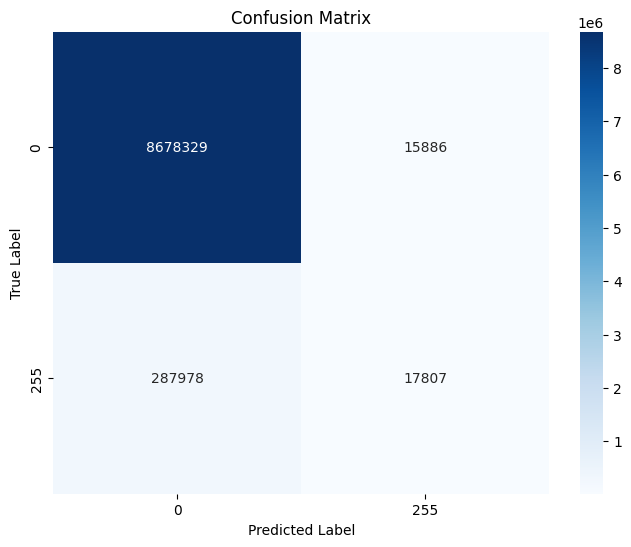

In [42]:
evaluate_model_with_confusion_matrix(ANNmodel1, test_csv)

In [61]:
output_csv = 'csv/metrics.csv'

evaluate_model(ANNmodel1, test_csv, output_csv)

Métricas guardadas en csv/metrics.csv


In [62]:
metrics_from_csv = pd.read_csv(output_csv)
print(metrics_from_csv)

             Metric     Value
0          F1 Score  0.104908
1            Recall  0.058234
2  Dice Coefficient  0.104908


In [43]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from PIL import Image

def predict_and_export(model, test_folder, csv_output_folder, image_output_folder, target_size=(1500, 1500)):
    # Crear carpetas de salida si no existen
    os.makedirs(csv_output_folder, exist_ok=True)
    os.makedirs(image_output_folder, exist_ok=True)

    # Obtener lista de imágenes en la carpeta de prueba
    test_files = os.listdir(test_folder)
    
    for test_file in test_files:
        # Ruta completa de la imagen de prueba
        img_path = os.path.join(test_folder, test_file)

        # Cargar la imagen y redimensionarla a 1500x1500
        img = Image.open(img_path).resize(target_size)
        
        # Convertir la imagen a un array numpy y aplanarla para la predicción
        img_array = np.array(img).reshape(-1, 3)
        
        # Crear un DataFrame con nombres de columnas para que coincidan con el entrenamiento
        img_df = pd.DataFrame(img_array, columns=['R', 'G', 'B'])
        
        # Predecir la etiqueta de cada píxel usando el modelo
        predictions = model.predict(img_df)

        # Guardar las predicciones en un CSV con el mismo nombre que la imagen
        csv_filename = f"{os.path.splitext(test_file)[0]}.csv"
        csv_path = os.path.join(csv_output_folder, csv_filename)
        pd.DataFrame(predictions, columns=['Label']).to_csv(csv_path, index=False)
        
        # Convertir las predicciones de vuelta a la forma de imagen y guardar como PNG
        pred_image = predictions.reshape(target_size)
        
        # Asegurar que la imagen se guarda como blanco y negro con valores de 0 y 255
        pred_image = (pred_image == 255).astype(np.uint8) * 255
        
        # Convertir a imagen y guardar en PNG
        pred_img = Image.fromarray(pred_image, mode='L')
        png_path = os.path.join(image_output_folder, f"{os.path.splitext(test_file)[0]}.png")
        pred_img.save(png_path)

        print(f"Predicción guardada para {test_file}: CSV en {csv_path}, imagen en {png_path}")


In [44]:
csv_output_folder = 'csv/predictions'
image_output_folder = 'DataSet_1/outputs'
predict_and_export(ANNmodel1, sat_folder_test,csv_output_folder, image_output_folder,target_size=(1500, 1500))

Predicción guardada para 10528675_15.tiff: CSV en csv/predictions\10528675_15.csv, imagen en DataSet_1/outputs\10528675_15.png
Predicción guardada para 10528690_15.tiff: CSV en csv/predictions\10528690_15.csv, imagen en DataSet_1/outputs\10528690_15.png
Predicción guardada para 10528705_15.tiff: CSV en csv/predictions\10528705_15.csv, imagen en DataSet_1/outputs\10528705_15.png
Predicción guardada para 10528720_15.tiff: CSV en csv/predictions\10528720_15.csv, imagen en DataSet_1/outputs\10528720_15.png


In [52]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_images(output_folder, sat_folder, gt_folder, target_size=(1500, 1500)):
    # Obtener lista de imágenes en la carpeta de salida
    output_files = os.listdir(output_folder)
    
    # Iterar sobre las imágenes
    for output_file in output_files:
        # Rutas completas de las imágenes
        output_path = os.path.join(output_folder, output_file)
        sat_path = os.path.join(sat_folder, f"{os.path.splitext(output_file)[0]}.tiff")  # Asumiendo extensión .tiff para sat
        gt_path = os.path.join(gt_folder, f"{os.path.splitext(output_file)[0]}.tif")  # Asumiendo extensión .tiff para gt
        
        # Comprobar que la imagen de sat y gt existen
        if os.path.exists(sat_path) and os.path.exists(gt_path):
            # Cargar las imágenes
            output_img = Image.open(output_path).resize(target_size)
            sat_img = Image.open(sat_path).resize(target_size)
            gt_img = Image.open(gt_path).resize(target_size)
            
            # Convertir imágenes a arrays numpy para mejor visualización
            output_array = np.array(output_img)
            sat_array = np.array(sat_img)
            gt_array = np.array(gt_img)
            
            # Crear figura para los 3 subplots
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Plotear imagen satelital
            axes[0].imshow(sat_array)
            axes[0].set_title(f"Satellite Image: {output_file}")
            axes[0].axis('off')
            
            # Plotear máscara de ground truth
            axes[1].imshow(gt_array, cmap='gray')
            axes[1].set_title(f"Ground Truth: {output_file}")
            axes[1].axis('off')
            
            # Plotear predicción
            axes[2].imshow(output_array, cmap='gray')
            axes[2].set_title(f"Prediction: {output_file}")
            axes[2].axis('off')
            
            # Mostrar el plot
            plt.show()
        else:
            print(f"Imagen de prueba o máscara no encontrada para: {output_file}")




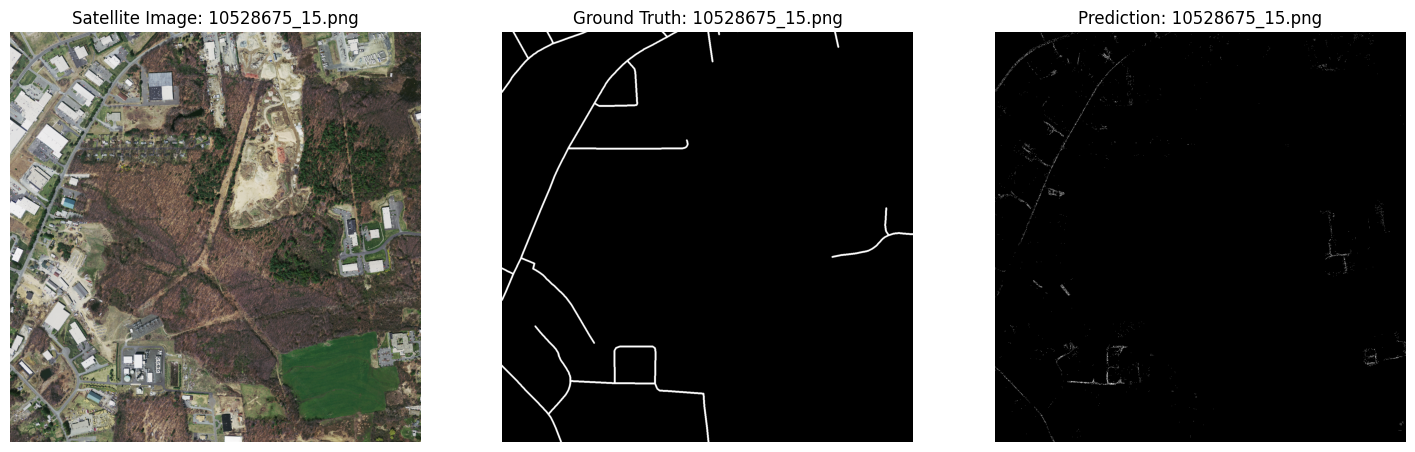

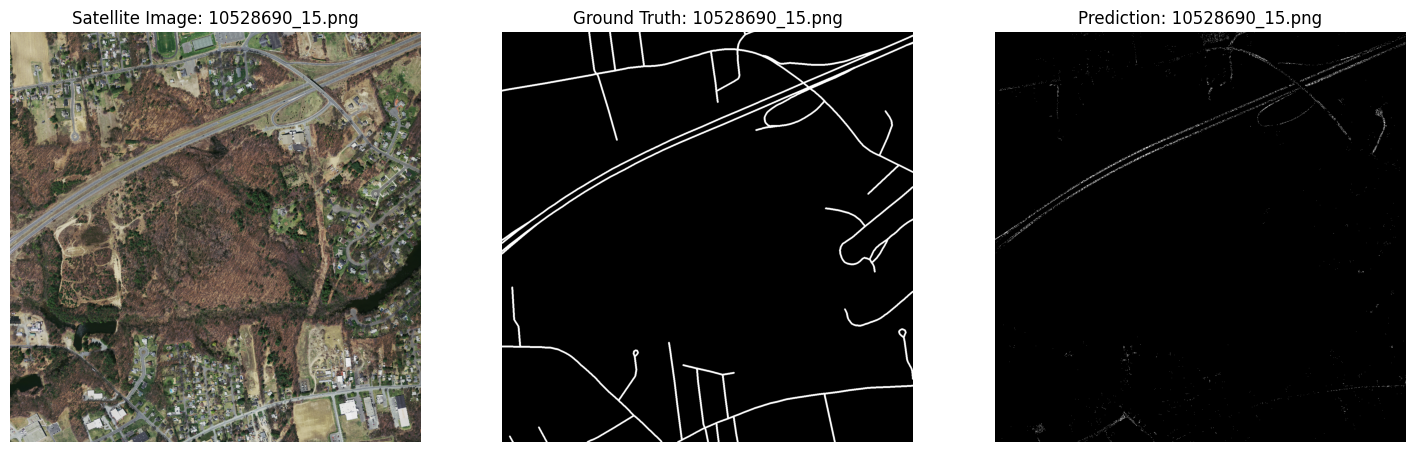

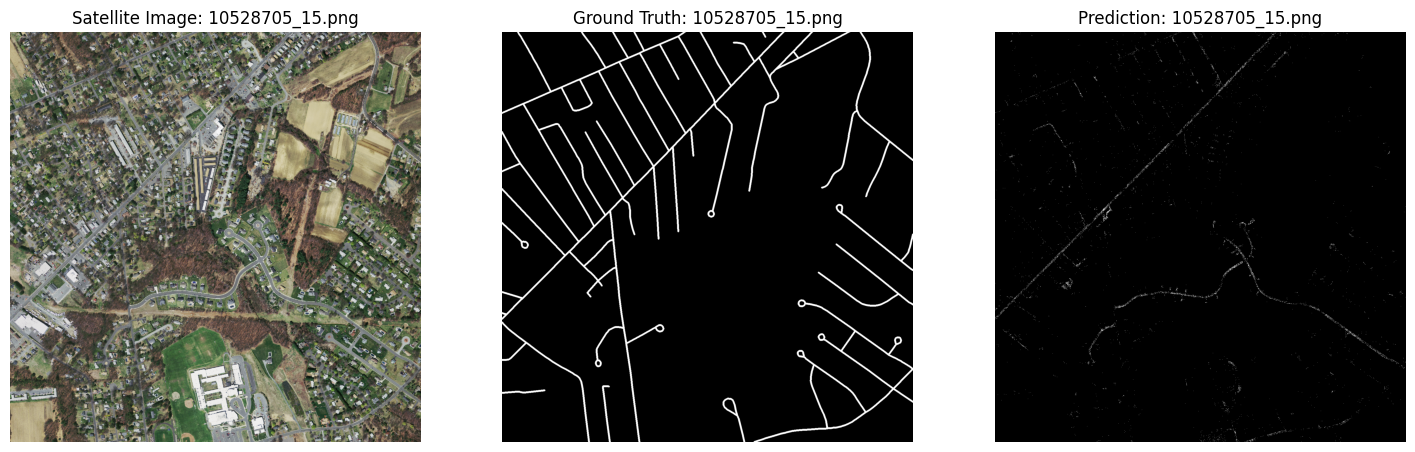

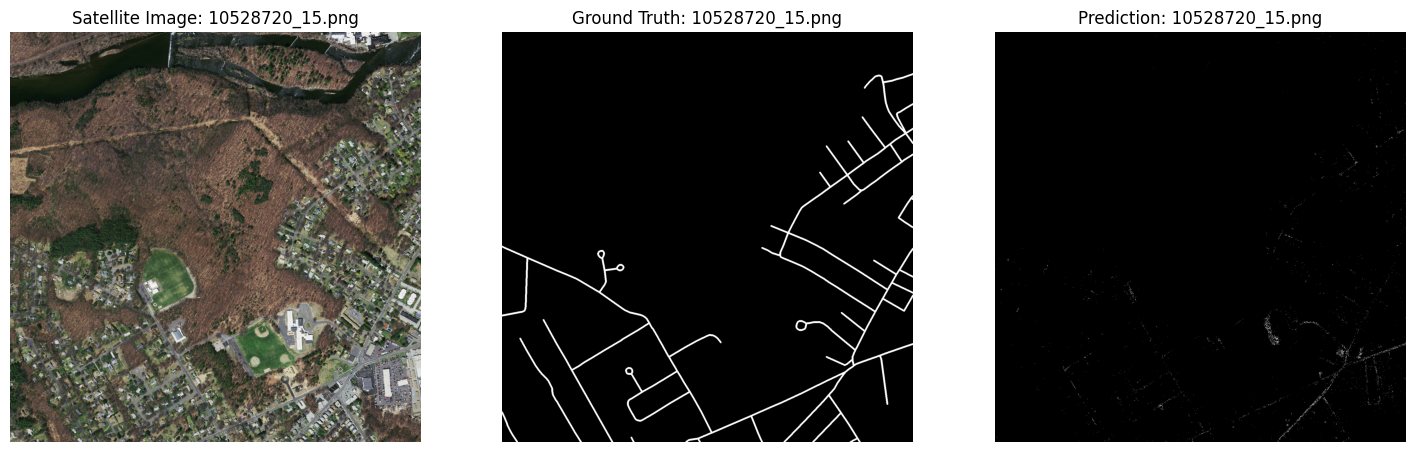

In [53]:
# Ejemplo de uso
output_folder = 'DataSet_1/outputs'
sat_folder = 'DataSet_1/test/sat'
gt_folder = 'DataSet_1/test/gt'

plot_images(output_folder, sat_folder, gt_folder)

In [45]:
reset_folders(sat_folder, gt_folder, sat_folder_test, gt_folder_test)

Todas las imágenes han sido devueltas a sus carpetas originales.
